<a href="https://colab.research.google.com/github/christinaxliu/research/blob/main/Caltech-JPL-Intern/HZExoplanetClassifiers/DecisionTreeClassifier/HZExoplanet_DesicionTree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
'''
Decision tree v1 classifier for predicting habitable zone exoplanets.

Training data is based on Confirmed Planets Discovered by Kepler (NASA Exoplanet Archive):
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag%3E0&constraint=disc_facility%20like%20%27%25Kepler%25%27

The criteria to determine whether an exoplanet is in Habitable Zone (HZ) or not is based on the conditions list on NASA Exoplanet Archive webpage:
https://exoplanetarchive.ipac.caltech.edu/docs/counts_detail.html
    Candidates and Confirmed in Habitable Zone
        * (180 K < Equilibrium (T) < 310 K) or
        * (0.25 < Insolation (Earth flux) < 2.2)

After data cleaning and feature preparation, 31 postive samples and 213 negative samples are left in the training data.
The training data is splitted with 60% used for training (with over-smapling to handle the data imbalance issue), and 40% reserved for testing.
'''


from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import pickle
from google.colab import drive

In [30]:
warnings.filterwarnings('ignore')
pd.options.mode.copy_on_write = True
plt.style.use('fivethirtyeight')

In [31]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/HZExoplanetClassifiers/DecisionTreeClassifier/KeplerConfirmedExoplanets_2024.06.29.csv'
exoplanets_data = pd.read_table(exoplanets_filename,
                                skiprows=98,
                                sep=',',
                                header=None,
                                index_col=None,
                                names = ['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility',
                                          'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2',
                                          'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
                                          'pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_massj', 'pl_massjerr1', 'pl_massjerr2',
                                          'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2',
                                          'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
                                          'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2',
                                          'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_rad', 'st_raderr1', 'st_raderr2',
                                          'st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2',
                                          'st_metratio', 'st_lum', 'st_lumerr1', 'st_lumerr2', 'st_logg', 'st_loggerr1', 'st_loggerr2',
                                          'st_age', 'st_ageerr1', 'st_ageerr2', 'st_dens', 'st_denserr1', 'st_denserr2', 'st_vsin',
                                          'st_vsinerr1', 'st_vsinerr2', 'st_rotp', 'st_rotperr1', 'st_rotperr2', 'st_radv', 'st_radverr1',
                                          'st_radverr2', 'sy_dist', 'sy_disterr1', 'sy_disterr2', 'sy_bmag', 'sy_bmagerr1', 'sy_bmagerr2', 'sy_vmag',
                                          'sy_vmagerr1', 'sy_vmagerr2'],
                                skipfooter=0,
                                engine='python')

In [33]:
# Sanity check the first several rows of data to ensure data is read correctly
exoplanets_data.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbpererr1,...,st_radverr2,sy_dist,sy_disterr1,sy_disterr2,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_vmag,sy_vmagerr1,sy_vmagerr2
0,2MASS J19383260+4603591 b,2MASS J19383260+4603591,1,2,3,Eclipse Timing Variations,2015,Kepler,406.000000,4.000000,...,NaN,396.332,6.3885,-6.3885,12.112,0.307,-0.307,12.651,0.215,-0.215
1,KIC 10001893 b,KIC 10001893,1,1,3,Orbital Brightness Modulation,2014,Kepler,0.219700,NaN,...,NaN,1672.940,149.7000,-149.7000,15.073,0.109,-0.109,15.829,0.150,-0.150
2,KIC 10001893 c,KIC 10001893,1,1,3,Orbital Brightness Modulation,2014,Kepler,0.325280,NaN,...,NaN,1672.940,149.7000,-149.7000,15.073,0.109,-0.109,15.829,0.150,-0.150
3,KIC 10001893 d,KIC 10001893,1,1,3,Orbital Brightness Modulation,2014,Kepler,0.811610,NaN,...,NaN,1672.940,149.7000,-149.7000,15.073,0.109,-0.109,15.829,0.150,-0.150
4,KIC 10068024 b,KIC 10068024,1,1,1,Orbital Brightness Modulation,2021,Kepler,2.073549,0.000008,...,NaN,721.105,NaN,NaN,13.685,0.087,-0.087,13.144,0.092,-0.092


In [34]:
# Sanity check the last several rows of data to ensure data is read correctly.
exoplanets_data.tail()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbpererr1,...,st_radverr2,sy_dist,sy_disterr1,sy_disterr2,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_vmag,sy_vmagerr1,sy_vmagerr2
2769,Kepler-997 b,Kepler-997,1,1,1,Transit,2016,Kepler,2.707307,0.000006,...,NaN,467.568,5.707,-5.574,12.794,0.312,-0.312,11.521,0.038,-0.038
2770,Kepler-998 b,Kepler-998,1,1,1,Transit,2016,Kepler,5.653777,0.000011,...,NaN,986.364,15.666,-15.197,15.304,0.023,-0.023,14.463,0.080,-0.080
2771,Kepler-999 b,Kepler-999,1,1,1,Transit,2016,Kepler,5.991857,0.000008,...,NaN,545.063,8.197,-7.962,13.045,0.016,-0.016,12.364,0.069,-0.069
2772,PH1 b,PH1,1,4,1,Transit,2012,Kepler,138.317000,0.040000,...,-0.2,1033.160,NaN,NaN,14.932,0.067,-0.067,13.841,0.149,-0.149
2773,PH2 b,PH2,1,1,1,Transit,2013,Kepler,282.525420,0.000110,...,NaN,343.863,3.631,-3.557,13.446,0.023,-0.023,12.645,0.046,-0.046


In [35]:
# Get the statistics about the data
exoplanets_data.describe()

,default_flag,sy_snum,sy_pnum,disc_year,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,...,st_radverr2,sy_dist,sy_disterr1,sy_disterr2,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_vmag,sy_vmagerr1,sy_vmagerr2
count,2774.0,2774.000000,2774.000000,2774.000000,2774.000000,2330.000000,2330.000000,1004.000000,225.000000,225.000000,...,53.000000,2697.000000,2605.000000,2605.000000,2738.000000,2738.000000,2738.000000,2774.000000,2774.00000,2774.00000
mean,1.0,1.044701,1.876352,2015.966474,32.409955,1.233449,-0.327138,0.170554,0.029845,-0.021249,...,-0.221698,822.496410,24.935287,-23.305747,15.352788,0.073115,-0.073115,14.528330,0.13487,-0.13487
std,0.0,0.223451,1.176245,2.632557,90.774635,50.365528,14.517035,0.260871,0.167735,0.080998,...,0.347672,449.530121,49.152204,40.184245,1.422158,0.073592,0.073592,1.292512,0.13205,0.13205
min,1.0,1.000000,1.000000,2009.000000,0.219700,0.000000,-700.000000,0.006000,0.000120,-0.900000,...,-1.100000,36.439600,0.039500,-1073.720000,8.431000,0.000000,-0.575000,8.250000,0.00200,-1.13300
25%,1.0,1.000000,1.000000,2014.000000,5.145515,0.000013,-0.000185,0.062000,0.001000,-0.010000,...,-0.200000,489.876000,5.349000,-26.955000,14.560250,0.031000,-0.070000,13.752000,0.08000,-0.14900
50%,1.0,1.000000,1.000000,2016.000000,11.456085,0.000049,-0.000049,0.103000,0.002700,-0.002700,...,-0.100000,771.494000,12.838000,-12.677000,15.522000,0.064000,-0.064000,14.793500,0.10300,-0.10300
75%,1.0,1.000000,2.000000,2016.000000,27.079978,0.000184,-0.000013,0.181000,0.010000,-0.001000,...,-0.010000,1047.030000,27.690000,-5.282500,16.308000,0.070000,-0.031000,15.489000,0.14900,-0.08000
max,1.0,4.000000,8.000000,2023.000000,2500.000000,2400.000000,0.000000,4.200000,2.400000,-0.000130,...,0.000000,3460.510000,1507.570000,-0.039400,19.340000,0.575000,0.000000,18.190000,1.13300,-0.00200


In [36]:
# Cast numericl values to floats
exoplanets_data['sy_snum'] = exoplanets_data['sy_snum'].astype(int)
exoplanets_data['sy_pnum'] = exoplanets_data['sy_pnum'].astype(int)
exoplanets_data['disc_year'] = exoplanets_data['disc_year'].astype(int)
exoplanets_data['pl_orbper'] = exoplanets_data['pl_orbper'].astype(float)
exoplanets_data['pl_orbpererr1'] = exoplanets_data['pl_orbpererr1'].astype(float)
exoplanets_data['pl_orbpererr2'] = exoplanets_data['pl_orbpererr2'].astype(float)
exoplanets_data['pl_orbsmax'] = exoplanets_data['pl_orbsmax'].astype(float)
exoplanets_data['pl_orbsmaxerr1'] = exoplanets_data['pl_orbsmaxerr1'].astype(float)
exoplanets_data['pl_orbsmaxerr2'] = exoplanets_data['pl_orbsmaxerr2'].astype(float)
exoplanets_data['pl_rade'] = exoplanets_data['pl_rade'].astype(float)
exoplanets_data['pl_radeerr1'] = exoplanets_data['pl_radeerr1'].astype(float)
exoplanets_data['pl_radeerr2'] = exoplanets_data['pl_radeerr2'].astype(float)
exoplanets_data['pl_radj'] = exoplanets_data['pl_radj'].astype(float)
exoplanets_data['pl_radjerr1'] = exoplanets_data['pl_radjerr1'].astype(float)
exoplanets_data['pl_radjerr2'] = exoplanets_data['pl_radjerr2'].astype(float)
exoplanets_data['pl_masse'] = exoplanets_data['pl_masse'].astype(float)
exoplanets_data['pl_masseerr1'] = exoplanets_data['pl_masseerr1'].astype(float)
exoplanets_data['pl_masseerr2'] = exoplanets_data['pl_masseerr2'].astype(float)
exoplanets_data['pl_massj'] = exoplanets_data['pl_massj'].astype(float)
exoplanets_data['pl_massjerr1'] = exoplanets_data['pl_massjerr1'].astype(float)
exoplanets_data['pl_massjerr2'] = exoplanets_data['pl_massjerr2'].astype(float)
exoplanets_data['pl_dens'] = exoplanets_data['pl_dens'].astype(float)
exoplanets_data['pl_denserr1'] = exoplanets_data['pl_denserr1'].astype(float)
exoplanets_data['pl_denserr2'] = exoplanets_data['pl_denserr2'].astype(float)
exoplanets_data['pl_orbeccen'] = exoplanets_data['pl_orbeccen'].astype(float)
exoplanets_data['pl_orbeccenerr1'] = exoplanets_data['pl_orbeccenerr1'].astype(float)
exoplanets_data['pl_orbeccenerr2'] = exoplanets_data['pl_orbeccenerr2'].astype(float)
exoplanets_data['pl_insol'] = exoplanets_data['pl_insol'].astype(float)
exoplanets_data['pl_insolerr1'] = exoplanets_data['pl_insolerr1'].astype(float)
exoplanets_data['pl_insolerr2'] = exoplanets_data['pl_insolerr2'].astype(float)
exoplanets_data['pl_eqt'] = exoplanets_data['pl_eqt'].astype(float)
exoplanets_data['pl_eqterr1'] = exoplanets_data['pl_eqterr1'].astype(float)
exoplanets_data['pl_eqterr2'] = exoplanets_data['pl_eqterr2'].astype(float)
exoplanets_data['pl_ratdor'] = exoplanets_data['pl_ratdor'].astype(float)
exoplanets_data['pl_ratdorerr1'] = exoplanets_data['pl_ratdorerr1'].astype(float)
exoplanets_data['pl_ratdorerr2'] = exoplanets_data['pl_ratdorerr2'].astype(float)
exoplanets_data['pl_ratror'] = exoplanets_data['pl_ratror'].astype(float)
exoplanets_data['pl_ratrorerr1'] = exoplanets_data['pl_ratrorerr1'].astype(float)
exoplanets_data['pl_ratrorerr2'] = exoplanets_data['pl_ratrorerr2'].astype(float)
exoplanets_data['st_spectype'] = exoplanets_data['st_spectype'].astype(str)
exoplanets_data['st_teff'] = exoplanets_data['st_teff'].astype(float)
exoplanets_data['st_tefferr1'] = exoplanets_data['st_tefferr1'].astype(float)
exoplanets_data['st_tefferr2'] = exoplanets_data['st_tefferr2'].astype(float)
exoplanets_data['st_rad'] = exoplanets_data['st_rad'].astype(float)
exoplanets_data['st_raderr1'] = exoplanets_data['st_raderr1'].astype(float)
exoplanets_data['st_raderr2'] = exoplanets_data['st_raderr2'].astype(float)
exoplanets_data['st_mass'] = exoplanets_data['st_mass'].astype(float)
exoplanets_data['st_masserr1'] = exoplanets_data['st_masserr1'].astype(float)
exoplanets_data['st_masserr2'] = exoplanets_data['st_masserr2'].astype(float)
exoplanets_data['st_met'] = exoplanets_data['st_met'].astype(float)
exoplanets_data['st_meterr1'] = exoplanets_data['st_meterr1'].astype(float)
exoplanets_data['st_meterr2'] = exoplanets_data['st_meterr2'].astype(float)
exoplanets_data['st_lum'] = exoplanets_data['st_lum'].astype(float)
exoplanets_data['st_lumerr1'] = exoplanets_data['st_lumerr1'].astype(float)
exoplanets_data['st_lumerr2'] = exoplanets_data['st_lumerr2'].astype(float)
exoplanets_data['st_logg'] = exoplanets_data['st_logg'].astype(float)
exoplanets_data['st_loggerr1'] = exoplanets_data['st_loggerr1'].astype(float)
exoplanets_data['st_loggerr2'] = exoplanets_data['st_loggerr2'].astype(float)
exoplanets_data['st_age'] = exoplanets_data['st_age'].astype(float)
exoplanets_data['st_ageerr1'] = exoplanets_data['st_ageerr1'].astype(float)
exoplanets_data['st_ageerr2'] = exoplanets_data['st_ageerr2'].astype(float)
exoplanets_data['st_dens'] = exoplanets_data['st_dens'].astype(float)
exoplanets_data['st_denserr1'] = exoplanets_data['st_denserr1'].astype(float)
exoplanets_data['st_denserr2'] = exoplanets_data['st_denserr2'].astype(float)
exoplanets_data['st_vsin'] = exoplanets_data['st_vsin'].astype(float)
exoplanets_data['st_vsinerr1'] = exoplanets_data['st_vsinerr1'].astype(float)
exoplanets_data['st_vsinerr2'] = exoplanets_data['st_vsinerr2'].astype(float)
exoplanets_data['st_rotp'] = exoplanets_data['st_rotp'].astype(float)
exoplanets_data['st_rotperr1'] = exoplanets_data['st_rotperr1'].astype(float)
exoplanets_data['st_rotperr2'] = exoplanets_data['st_rotperr2'].astype(float)
exoplanets_data['st_radv'] = exoplanets_data['st_radv'].astype(float)
exoplanets_data['st_radverr1'] = exoplanets_data['st_radverr1'].astype(float)
exoplanets_data['st_radverr2'] = exoplanets_data['st_radverr2'].astype(float)
exoplanets_data['sy_dist'] = exoplanets_data['sy_dist'].astype(float)
exoplanets_data['sy_disterr1'] = exoplanets_data['sy_disterr1'].astype(float)
exoplanets_data['sy_disterr2'] = exoplanets_data['sy_disterr2'].astype(float)
exoplanets_data['sy_bmag'] = exoplanets_data['sy_bmag'].astype(float)
exoplanets_data['sy_bmagerr1'] = exoplanets_data['sy_bmagerr1'].astype(float)
exoplanets_data['sy_bmagerr2'] = exoplanets_data['sy_bmagerr2'].astype(float)
exoplanets_data['sy_vmag'] = exoplanets_data['sy_vmag'].astype(float)
exoplanets_data['sy_vmagerr1'] = exoplanets_data['sy_vmagerr1'].astype(float)
exoplanets_data['sy_vmagerr2'] = exoplanets_data['sy_vmagerr2'].astype(float)

In [42]:
# Change any fields with empty spaces to NaN values so we could clean them up later on
exoplanets_data = exoplanets_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)

In [43]:
exoplanets_data['pl_eqt'].describe()

count     213.000000
mean      883.272300
std       493.351927
min       134.000000
25%       478.000000
50%       798.000000
75%      1173.000000
max      2550.000000
Name: pl_eqt, dtype: float64

In [44]:
exoplanets_data['pl_insol'].describe()

count       157.000000
mean       3133.656433
std       34777.595821
min           0.210000
25%           5.950000
50%          51.320000
75%         315.000000
max      436000.000000
Name: pl_insol, dtype: float64

In [45]:
exoplanets_data.loc[((~np.isnan(exoplanets_data['pl_eqt'])) & (exoplanets_data['pl_eqt'] > 180) & (exoplanets_data['pl_eqt'] < 310)), 'hz_label_by_eqt'] = 1
exoplanets_data.loc[((~np.isnan(exoplanets_data['pl_eqt'])) & ((exoplanets_data['pl_eqt'] <= 180) | (exoplanets_data['pl_eqt'] >= 310))), 'hz_label_by_eqt'] = 0
exoplanets_data['hz_label_by_eqt'].value_counts()

hz_label_by_eqt
0.0    193
1.0     20
Name: count, dtype: int64

In [46]:
exoplanets_data.loc[((~np.isnan(exoplanets_data['pl_insol'])) & (exoplanets_data['pl_insol'] > 0.25) & (exoplanets_data['pl_insol'] < 2.2)), 'hz_label_by_insol'] = 1
exoplanets_data.loc[((~np.isnan(exoplanets_data['pl_insol'])) & ((exoplanets_data['pl_insol'] <= 0.25) | (exoplanets_data['pl_insol'] >= 2.2))), 'hz_label_by_insol'] = 0
exoplanets_data['hz_label_by_insol'].value_counts()

hz_label_by_insol
0.0    135
1.0     22
Name: count, dtype: int64

In [47]:
exoplanets_data.loc[(((~np.isnan(exoplanets_data['hz_label_by_eqt'])) & (exoplanets_data['hz_label_by_eqt'] == 1)) | ((~np.isnan(exoplanets_data['hz_label_by_insol'])) & (exoplanets_data['hz_label_by_insol'] == 1))), 'hz_label'] = 1
exoplanets_data.loc[(((~np.isnan(exoplanets_data['hz_label_by_eqt'])) & (exoplanets_data['hz_label_by_eqt'] == 0)) & ((~np.isnan(exoplanets_data['hz_label_by_insol'])) & (exoplanets_data['hz_label_by_insol'] == 0))), 'hz_label'] = 0
exoplanets_data.loc[(((~np.isnan(exoplanets_data['hz_label_by_eqt'])) & (exoplanets_data['hz_label_by_eqt'] == 0)) & (np.isnan(exoplanets_data['hz_label_by_insol']))), 'hz_label'] = 0
exoplanets_data.loc[((np.isnan(exoplanets_data['hz_label_by_eqt'])) & ((~np.isnan(exoplanets_data['hz_label_by_insol'])) & (exoplanets_data['hz_label_by_insol'] == 0))), 'hz_label'] = 0
exoplanets_data['hz_label'].value_counts()

hz_label
0.0    213
1.0     31
Name: count, dtype: int64

In [48]:
# Drop off data row without label
training_data = exoplanets_data.loc[~np.isnan(exoplanets_data['hz_label'])]
training_data

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbpererr1,...,sy_disterr2,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,hz_label_by_eqt,hz_label_by_insol,hz_label
15,KOI-1257 b,KOI-1257,1,2,1,Transit,2014,Kepler,86.647661,3.400000e-05,...,NaN,15.830,0.098,-0.098,14.818,0.069,-0.069,0.0,NaN,0.0
16,KOI-13 b,KOI-13,1,3,1,Transit,2011,Kepler,1.763588,1.000000e-06,...,-27.5060,10.654,0.078,-0.078,9.791,0.023,-0.023,0.0,NaN,0.0
21,KOI-1783.01,KOI-1783,1,1,2,Transit,2020,Kepler,134.462800,3.300000e-03,...,-13.3200,14.686,0.081,-0.081,13.978,0.080,-0.080,NaN,0.0,0.0
22,KOI-1783.02,KOI-1783,1,1,2,Transit,2020,Kepler,284.215000,2.600000e-02,...,-13.3200,14.686,0.081,-0.081,13.978,0.080,-0.080,NaN,0.0,0.0
23,KOI-1831 d,Kepler-324,1,1,4,Transit,2021,Kepler,34.169000,NaN,...,-3.6290,15.762,0.068,-0.068,14.222,0.069,-0.069,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,Kepler-93 b,Kepler-93,1,1,2,Transit,2014,Kepler,4.726740,9.700000e-07,...,-0.2206,10.731,0.062,-0.062,9.996,0.004,-0.004,0.0,0.0,0.0
2710,Kepler-949 c,Kepler-949,1,1,2,Transit,2023,Kepler,20.997580,3.334000e-05,...,-5.3870,15.720,0.031,-0.031,14.718,0.172,-0.172,0.0,0.0,0.0
2744,Kepler-975 c,Kepler-975,1,1,2,Transit,2023,Kepler,5.058213,4.740000e-06,...,-3.5640,16.118,0.065,-0.065,14.633,0.046,-0.046,0.0,0.0,0.0
2772,PH1 b,PH1,1,4,1,Transit,2012,Kepler,138.317000,4.000000e-02,...,NaN,14.932,0.067,-0.067,13.841,0.149,-0.149,0.0,NaN,0.0


In [49]:
# Drop data fields that are not relevant to training or don't provide value to training
training_data = training_data.drop(['pl_name'], axis = 1)
training_data = training_data.drop(['hostname'], axis = 1)
training_data = training_data.drop(['default_flag'], axis = 1)
training_data = training_data.drop(['discoverymethod'], axis = 1)
training_data = training_data.drop(['disc_year'], axis = 1)
training_data = training_data.drop(['disc_facility'], axis = 1)
training_data = training_data.drop(['pl_orbpererr1'], axis = 1)
training_data = training_data.drop(['pl_orbpererr2'], axis = 1)
training_data = training_data.drop(['pl_orbsmaxerr1'], axis = 1)
training_data = training_data.drop(['pl_orbsmaxerr2'], axis = 1)
training_data = training_data.drop(['pl_radeerr1'], axis = 1)
training_data = training_data.drop(['pl_radeerr2'], axis = 1)
training_data = training_data.drop(['pl_radjerr1'], axis = 1)
training_data = training_data.drop(['pl_radjerr2'], axis = 1)
training_data = training_data.drop(['pl_masseerr1'], axis = 1)
training_data = training_data.drop(['pl_masseerr2'], axis = 1)
training_data = training_data.drop(['pl_massjerr1'], axis = 1)
training_data = training_data.drop(['pl_massjerr2'], axis = 1)
training_data = training_data.drop(['pl_denserr1'], axis = 1)
training_data = training_data.drop(['pl_denserr2'], axis = 1)
training_data = training_data.drop(['pl_orbeccenerr1'], axis = 1)
training_data = training_data.drop(['pl_orbeccenerr2'], axis = 1)
training_data = training_data.drop(['pl_insolerr1'], axis = 1)
training_data = training_data.drop(['pl_insolerr2'], axis = 1)
training_data = training_data.drop(['pl_eqterr1'], axis = 1)
training_data = training_data.drop(['pl_eqterr2'], axis = 1)
training_data = training_data.drop(['pl_ratdorerr1'], axis = 1)
training_data = training_data.drop(['pl_ratdorerr2'], axis = 1)
training_data = training_data.drop(['pl_ratrorerr1'], axis = 1)
training_data = training_data.drop(['pl_ratrorerr2'], axis = 1)
training_data = training_data.drop(['st_spectype'], axis = 1)
training_data = training_data.drop(['st_tefferr1'], axis = 1)
training_data = training_data.drop(['st_tefferr2'], axis = 1)
training_data = training_data.drop(['st_raderr1'], axis = 1)
training_data = training_data.drop(['st_raderr2'], axis = 1)
training_data = training_data.drop(['st_masserr1'], axis = 1)
training_data = training_data.drop(['st_masserr2'], axis = 1)
training_data = training_data.drop(['st_meterr1'], axis = 1)
training_data = training_data.drop(['st_meterr2'], axis = 1)
training_data = training_data.drop(['st_metratio'], axis = 1)
training_data = training_data.drop(['st_lumerr1'], axis = 1)
training_data = training_data.drop(['st_lumerr2'], axis = 1)
training_data = training_data.drop(['st_loggerr1'], axis = 1)
training_data = training_data.drop(['st_loggerr2'], axis = 1)
training_data = training_data.drop(['st_ageerr1'], axis = 1)
training_data = training_data.drop(['st_ageerr2'], axis = 1)
training_data = training_data.drop(['st_denserr1'], axis = 1)
training_data = training_data.drop(['st_denserr2'], axis = 1)
training_data = training_data.drop(['st_vsinerr1'], axis = 1)
training_data = training_data.drop(['st_vsinerr2'], axis = 1)
training_data = training_data.drop(['st_rotperr1'], axis = 1)
training_data = training_data.drop(['st_rotperr2'], axis = 1)
training_data = training_data.drop(['st_radverr1'], axis = 1)
training_data = training_data.drop(['st_radverr2'], axis = 1)
training_data = training_data.drop(['sy_dist'], axis = 1)
training_data = training_data.drop(['sy_disterr1'], axis = 1)
training_data = training_data.drop(['sy_disterr2'], axis = 1)
training_data = training_data.drop(['sy_bmagerr1'], axis = 1)
training_data = training_data.drop(['sy_bmagerr2'], axis = 1)
training_data = training_data.drop(['sy_vmagerr1'], axis = 1)
training_data = training_data.drop(['sy_vmagerr2'], axis = 1)

training_data.to_csv('/content/drive/My Drive/Colab Notebooks/HZExoplanetClassifiers/DecisionTreeClassifier/TrainingData_DropInrelevantFields.csv')

# Drop data fields that are with too many missing values
training_data = training_data.drop(['st_lum'], axis = 1)
training_data = training_data.drop(['st_vsin'], axis = 1)
training_data = training_data.drop(['st_rotp'], axis = 1)
training_data = training_data.drop(['st_radv'], axis = 1)

# Drop exoplanet radius [Jupiter Mass] and mass [Jupiter Mass] data fileds as they are redundant to the corresponding fields in Earth metrics
training_data = training_data.drop(['pl_radj'], axis = 1)
training_data = training_data.drop(['pl_massj'], axis = 1)

# Drop data fileds of Exoplanent Equilibrium Temperature and Insolation Flux as they are used for labeling samples
training_data = training_data.drop(['pl_eqt'], axis = 1)
training_data = training_data.drop(['pl_insol'], axis = 1)
training_data = training_data.drop(['hz_label_by_eqt'], axis = 1)
training_data = training_data.drop(['hz_label_by_insol'], axis = 1)

training_data.to_csv('/content/drive/My Drive/Colab Notebooks/HZExoplanetClassifiers/DecisionTreeClassifier/TrainingData_Final.csv')
training_data

,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_masse,pl_dens,pl_orbeccen,pl_ratdor,pl_ratror,st_teff,st_rad,st_mass,st_met,st_logg,st_age,st_dens,sy_bmag,sy_vmag,hz_label
15,2,1,86.647661,0.38200,10.540,460.83000,2.10,0.77200,NaN,NaN,5520.0,1.13,0.99,0.270,4.32,9.3,0.9900,15.830,14.818,0.0
16,3,1,1.763588,0.03641,16.948,2949.46240,3.60,0.00064,4.5007,0.08737,7650.0,1.74,1.72,0.200,4.20,NaN,NaN,10.654,9.791,0.0
21,1,2,134.462800,NaN,8.860,71.00000,0.56,0.00000,94.8000,0.07102,5922.0,1.14,1.08,0.110,4.30,NaN,NaN,14.686,13.978,0.0
22,1,2,284.215000,NaN,5.440,15.00000,0.51,0.00000,NaN,NaN,5922.0,1.14,1.08,0.110,4.30,NaN,NaN,14.686,13.978,0.0
23,1,4,34.169000,NaN,1.130,2.23000,9.95,NaN,NaN,NaN,5233.0,0.83,0.90,NaN,NaN,NaN,NaN,15.762,14.222,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,1,2,4.726740,0.05343,1.478,4.66000,7.93,0.00000,NaN,NaN,5669.0,0.92,0.91,-0.180,NaN,6.6,NaN,10.731,9.996,0.0
2710,1,2,20.997580,0.13940,2.970,NaN,NaN,0.00000,64.9000,0.03036,5211.0,0.90,0.82,0.080,4.45,NaN,11.7201,15.720,14.718,0.0
2744,1,2,5.058213,0.05670,10.690,NaN,NaN,0.00000,11.5300,0.05871,4883.0,1.67,0.95,0.560,3.97,NaN,1.1333,16.118,14.633,0.0
2772,4,1,138.317000,0.65200,6.180,169.00000,NaN,0.07020,22.1435,0.03268,6407.0,1.73,1.53,0.210,4.14,2.0,0.2930,14.932,13.841,0.0


In [50]:
# Apply simple imputation by filling in missing values with mean
training_data = training_data.fillna(training_data.mean())
training_data = training_data.dropna()
training_data

,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_masse,pl_dens,pl_orbeccen,pl_ratdor,pl_ratror,st_teff,st_rad,st_mass,st_met,st_logg,st_age,st_dens,sy_bmag,sy_vmag,hz_label
15,2,1,86.647661,0.382000,10.540,460.830000,2.100000,0.772000,51.824267,0.045178,5520.0,1.13,0.99,0.270000,4.320000,9.30000,0.990000,15.830,14.818,0.0
16,3,1,1.763588,0.036410,16.948,2949.462400,3.600000,0.000640,4.500700,0.087370,7650.0,1.74,1.72,0.200000,4.200000,4.81007,2.283822,10.654,9.791,0.0
21,1,2,134.462800,0.237596,8.860,71.000000,0.560000,0.000000,94.800000,0.071020,5922.0,1.14,1.08,0.110000,4.300000,4.81007,2.283822,14.686,13.978,0.0
22,1,2,284.215000,0.237596,5.440,15.000000,0.510000,0.000000,51.824267,0.045178,5922.0,1.14,1.08,0.110000,4.300000,4.81007,2.283822,14.686,13.978,0.0
23,1,4,34.169000,0.237596,1.130,2.230000,9.950000,0.095548,51.824267,0.045178,5233.0,0.83,0.90,0.016279,4.394492,4.81007,2.283822,15.762,14.222,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,1,2,4.726740,0.053430,1.478,4.660000,7.930000,0.000000,51.824267,0.045178,5669.0,0.92,0.91,-0.180000,4.394492,6.60000,2.283822,10.731,9.996,0.0
2710,1,2,20.997580,0.139400,2.970,274.431855,6.784282,0.000000,64.900000,0.030360,5211.0,0.90,0.82,0.080000,4.450000,4.81007,11.720100,15.720,14.718,0.0
2744,1,2,5.058213,0.056700,10.690,274.431855,6.784282,0.000000,11.530000,0.058710,4883.0,1.67,0.95,0.560000,3.970000,4.81007,1.133300,16.118,14.633,0.0
2772,4,1,138.317000,0.652000,6.180,169.000000,6.784282,0.070200,22.143500,0.032680,6407.0,1.73,1.53,0.210000,4.140000,2.00000,0.293000,14.932,13.841,0.0


In [51]:
# all columns except "hz_lable" become features in the data for model training and testing.
# "hz_label" is the label in the data for model training and testing
features = training_data.drop(['hz_label'], axis = 1)
labels = training_data.hz_label

In [52]:
# we have 213 negative and 31 positive samples in the training data
# the training data is inbalanced; we'll use oversampling to handle this later on
labels.value_counts()

hz_label
0.0    213
1.0     31
Name: count, dtype: int64

In [53]:
# searching for the optimal max depth for the decision tree
def search_optimal_max_tree_depth(features,
                                  labels,
                                  start_max_depth,
                                  end_max_depth,
                                  stand_scaler,
                                  split_and_train_iteration_count,
                                  test_data_percentage,
                                  shuffle_during_split=True,
                                  show_progress=True):
    print(f"Searching the optimal decision tree max depth in between {start_max_depth} ~ {end_max_depth} \n\nIn progress...")

    mean_error_rates_by_max_depths = []

    # For each max_tree_depth in the [start_max_depth, end_max_depth] range, we train the model number of times specified by the input parameter
    # split_and_train_iteration_count and caluclate the error rate for each of the model obtained from the training. We then average the error
    # rates from all of models for a specific max_tree_depth and the average error rate becomes the mean error rate for the current max_tree_depth, which
    # is recorded by the corresonding items in the mean_error_rates_specific_max_depth array. After we loop through all the max_tree_depth in the
    # [start_max_depth, end_max_depth] range, the one with lowest average error rate is the optimal max_tree_dpeth.
    #
    # To compute the error rate for each model training, we use the model to predict the results using the testing data, and then compare the
    # prediction results with the labels (ground truth).
    for i in range(start_max_depth, end_max_depth + 1):
        mean_error_rates_specific_max_depth = []

        # Train the model number of times specified by the input parameter split_and_train_iteration_count, with the max_tree_depth specified by i
        for j in range(split_and_train_iteration_count):

            # Split data with training and testing with ratio specified by the input parameter test_data_percentage
            #
            # We also randomly shuffle the data before the splitting so each model training will have different sets of training data and testing data to
            # avoid potential overfitting (in which the model is trained in a way that is biased to the specific training data but with poor results when
            # applied to the data that it never sees before)
            features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                        labels,
                                                                                        test_size=test_data_percentage,
                                                                                        random_state=0,
                                                                                        shuffle=shuffle_during_split)
            # Standadize the scales of features
            features_train_sc = stand_scaler.fit_transform(features_train)
            features_test_sc = stand_scaler.transform(features_test)

            # Randomly over sample the positive samples to balance training data
            ros = RandomOverSampler(random_state=0)
            features_train_sc_ros, labels_train_ros = ros.fit_resample(features_train_sc, labels_train)

            # Train a decision tree model with max_tree_depth at i, and use entropy as the criterion to measure how well each split is during training
            decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
            decision_tree_classifier.fit(features_train_sc_ros, labels_train_ros)

            # Use the model to predict the results with the testing data, and then compare the prediction results with the labels (ground truth). This becomes
            # the error rate for this specific model
            mean_prediction_error_rate = np.mean(decision_tree_classifier.predict(features_test_sc) != labels_test)
            mean_error_rates_specific_max_depth.append(mean_prediction_error_rate)

        mean_error_rates_by_max_depths.append(np.mean(mean_error_rates_specific_max_depth))
        if show_progress == True:
                print(f'For decision tree with max depth {i}, mean prediction error rate = {np.mean(mean_error_rates_specific_max_depth):.3}')

    optimal_max_depth, optimal_mean_error_rate = mean_error_rates_by_max_depths.index(min(mean_error_rates_by_max_depths))+1, min(mean_error_rates_by_max_depths)
    print(f'\nDone! The Optimal Decision Tree Max Depth is: {optimal_max_depth}\n')

    # Display error rate v.s. tree max depth
    plt.figure(figsize = (7,5))
    plt.plot(range(start_max_depth, end_max_depth + 1),
             mean_error_rates_by_max_depths,
             'mo--',
             markersize=8,
             markerfacecolor='c',
             linewidth=1)

    # Mark the optimal tree max depth value
    plt.plot(optimal_max_depth,
             optimal_mean_error_rate,
             marker='o',
             markersize=8,
             markerfacecolor='gold',
             markeredgecolor='g')

    plt.title(f"The Optimal Decision Tree Max Depth is: {optimal_max_depth}",
              color='blue',
              fontsize=15)
    plt.ylabel("Mean Error Rate",
               color='black',
               fontsize = 13)
    plt.xlabel("Decision Tree Max Depth",
               color='black',
               fontsize = 13)

    return optimal_max_depth

Searching the optimal decision tree max depth in between 1 ~ 19 

In progress...
For decision tree with max depth 1, mean prediction error rate = 0.173
For decision tree with max depth 2, mean prediction error rate = 0.173
For decision tree with max depth 3, mean prediction error rate = 0.173
For decision tree with max depth 4, mean prediction error rate = 0.102
For decision tree with max depth 5, mean prediction error rate = 0.102
For decision tree with max depth 6, mean prediction error rate = 0.102
For decision tree with max depth 7, mean prediction error rate = 0.102
For decision tree with max depth 8, mean prediction error rate = 0.102
For decision tree with max depth 9, mean prediction error rate = 0.102
For decision tree with max depth 10, mean prediction error rate = 0.102
For decision tree with max depth 11, mean prediction error rate = 0.102
For decision tree with max depth 12, mean prediction error rate = 0.102
For decision tree with max depth 13, mean prediction error rate 

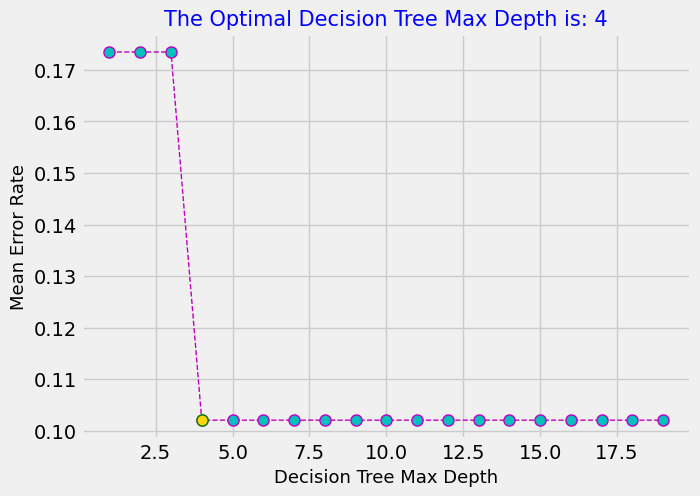

In [54]:
# Split data into training testing sets
split_test_data_percentage = 0.4

# Number of rounds to split into training & testing data and train the decision tree for each max depth to search for the optimal max depth
split_and_train_iteration_count = 100

stand_scaler = StandardScaler()

# Search for the optimal max depth for decision tree
optimal_max_depth = search_optimal_max_tree_depth(features=features,
                                                  labels=labels,
                                                  start_max_depth=1,
                                                  end_max_depth=len(features.columns),
                                                  stand_scaler=stand_scaler,
                                                  split_and_train_iteration_count=split_and_train_iteration_count,
                                                  test_data_percentage=split_test_data_percentage,
                                                  shuffle_during_split=True,
                                                  show_progress=True)

In [55]:
# split data with into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=split_test_data_percentage,
                                                                            random_state=0,
                                                                            shuffle=True)

# standadize the scales of features
features_train_sc = stand_scaler.fit_transform(features_train)
features_test_sc = stand_scaler.transform(features_test)

# randomly oversample the positive samples to balance training data
ros = RandomOverSampler()
features_train_sc_ros, labels_train_ros = ros.fit_resample(features_train_sc, labels_train)

In [56]:
# train a Decision Tree classifier with the training data
decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_max_depth, random_state=0)
decision_tree_classifier.fit(features_train_sc_ros, labels_train_ros)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [57]:
# Call trained Decision Tree classifier to get predictions for the testing data
labels_pred = decision_tree_classifier.predict(features_test_sc)

In [58]:
# calculate accuracy, precision, recall, and F-1 scores for the Decision Tree classifier
print("Decision Tree Classifier Accuracy: ", accuracy_score(labels_test, labels_pred))
print()
print("Decision Tree Classification Report :\n",(classification_report(labels_test,labels_pred)))

Decision Tree Classifier Accuracy:  0.8979591836734694

Decision Tree Classification Report :
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        83
         1.0       0.73      0.53      0.62        15

    accuracy                           0.90        98
   macro avg       0.82      0.75      0.78        98
weighted avg       0.89      0.90      0.89        98



,Feature Importance
Number of Stars,0.000000
Stellar Density [g/cm**3],0.000000
Stellar Age [Gyr],0.000000
Stellar Surface Gravity [log10(cm/s**2)],0.000000
Stellar Metallicity [dex],0.000000
Stellar Radius [Solar Radius],0.000000
Stellar Effective Temperature [K],0.000000
Stellar B (Johnson) Magnitude,0.000000
Ratio of Planet to Stellar Radius,0.000000
Planet Orbit Eccentricity,0.000000


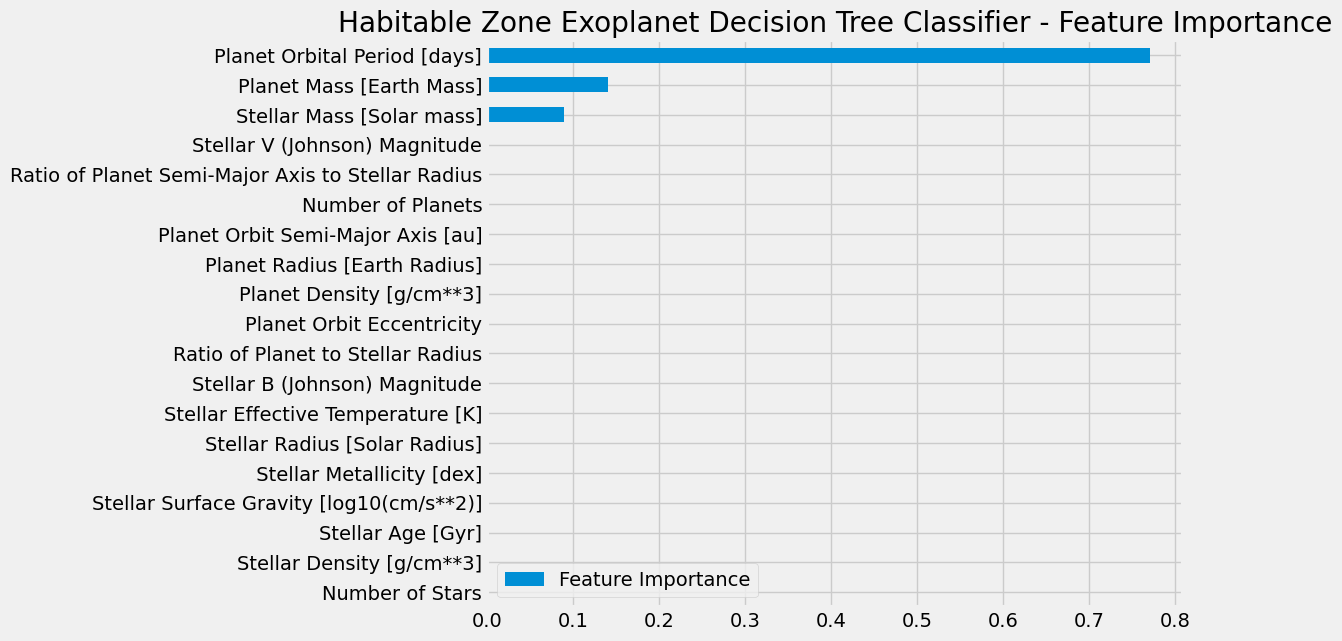

In [60]:
# Mapping from exoplanet type to the corresponding color in the plotting graph
feature_annotations = {
    'sy_snum': 'Number of Stars',
    'sy_pnum': 'Number of Planets',
    'pl_orbper': 'Planet Orbital Period [days]',
    'pl_orbsmax': 'Planet Orbit Semi-Major Axis [au]',
    'pl_rade': 'Planet Radius [Earth Radius]',
    'pl_masse': 'Planet Mass [Earth Mass]',
    'pl_dens': 'Planet Density [g/cm**3]',
    'pl_orbeccen': 'Planet Orbit Eccentricity',
    'pl_ratdor': 'Ratio of Planet Semi-Major Axis to Stellar Radius',
    'pl_ratror': 'Ratio of Planet to Stellar Radius',
    'st_teff': 'Stellar Effective Temperature [K]',
    'st_rad': 'Stellar Radius [Solar Radius]',
    'st_mass': 'Stellar Mass [Solar mass]',
    'st_met': ' Stellar Metallicity [dex]',
    'st_logg': 'Stellar Surface Gravity [log10(cm/s**2)]',
    'st_age': 'Stellar Age [Gyr]',
    'st_dens': 'Stellar Density [g/cm**3]',
    'sy_dist': 'Stellar Distance [pc]',
    'sy_bmag': 'Stellar B (Johnson) Magnitude',
    'sy_vmag': 'Stellar V (Johnson) Magnitude'
}

# Calculate and plot feature importance
feature_importances = pd.DataFrame(data=decision_tree_classifier.feature_importances_,
                                   index=features_train.columns.map(lambda x: feature_annotations[x]),
                                   columns=["Feature Importance"])
feature_importances.sort_values(by='Feature Importance', ascending=True, inplace=True)
feature_importances.plot(kind='barh',
                         figsize=(8,7),
                         title='Habitable Zone Exoplanet Decision Tree Classifier - Feature Importance',
                         grid=True)
feature_importances

In [61]:
# Save the Decision Tree classifier model onto disk
knnPickle = open('/content/drive/My Drive/Colab Notebooks/HZExoplanetClassifiers/DecisionTreeClassifier/hz_exoplanet_decision_tree_classifier_v1', 'wb')
pickle.dump(decision_tree_classifier, knnPickle)
knnPickle.close()

In [62]:
# Load the Decision Tree classifier model from disk and test with test data
loaded_decision_tree_classifier = pickle.load(open('/content/drive/My Drive/Colab Notebooks/HZExoplanetClassifiers/DecisionTreeClassifier/hz_exoplanet_decision_tree_classifier_v1', 'rb'))
pred_results = loaded_decision_tree_classifier.predict(features_test_sc)
pred_results

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])